# Initial imports and definitions

In [19]:
import zipfile
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import geopy.distance
from matplotlib import cm
from io import StringIO
import json

In [2]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import numpy as np

def plot_dendrogram(model, plot=False, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    order = dendrogram(linkage_matrix, no_plot = not plot, get_leaves=True, **kwargs)['leaves']
    return linkage_matrix, order


def elbow(data):
    elbowdata = np.array(data)
    if elbowdata.shape[1] != 2:
        elbowdata = elbowdata.T
    elbowdata -= elbowdata[0]
    rotation = np.linalg.inv(np.vstack([elbowdata[-1], [-elbowdata[-1,1], elbowdata[-1,0]]]).T)
    idx = np.argmin((elbowdata @rotation.T)[:,1])
    return idx    


def autocluster(data, return_order=False, return_linkage=False, plot=False, **kwargs):
    ag = AgglomerativeClustering(distance_threshold=0,n_clusters=None,**kwargs)
    ag.fit(data)
    linkage_matrix, order = plot_dendrogram(ag)
    idx = len(linkage_matrix) - elbow(list(enumerate(linkage_matrix[:,2])))
    if plot:
        plt.plot(linkage_matrix[:,2][::-1])
        plt.show()
    print("number of clusters: ", idx)
    ag2 = AgglomerativeClustering(n_clusters=idx, **kwargs)
    ag2.fit(data)
    ret = [ag2]
    if return_order:
        ret.append(order)
    if return_linkage:
        ret.append(linkage_matrix)
    return tuple(ret) if len(ret) > 1 else ret[0]

In [9]:
def plot_abq(data, first=True, **kwargs):
    if first:
        print('loading image')
        img = Image.open('abqmap2.png')
        plt.figure(figsize=(10,10))
        plt.imshow(img)
    for row in data:
        if 'latitude' in row:
            plot(row['latitude'], row['longitude'], **kwargs)
        else:
            plot(*row, **kwargs)
def plot(lat,lon,c, **kwargs):
    A = np.array([[ 3.30048468e+00, -1.76873312e+03],
       [ 1.44506111e+03, -7.69612341e+00],
       [ 1.54147586e+05,  6.14923771e+04]]).T
    pltx = A[1]@[lat,lon,1]
    plty = A[0]@[lat,lon,1]
    plt.scatter([plty], [pltx], color=c, **kwargs)

# right, need to convert lat/lon to euclidean
origin_x = -106.544256
origin_y = 35.034674
foot_x = 1
d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y, origin_x + foot_x)).feet
while abs(d-1) > 1e-5:
    if d > 1:
        foot_x *= 0.9
    else:
        foot_x *= 1.05
        
    d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y, origin_x + foot_x)).feet
foot_y = 1
d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y+foot_y, origin_x)).feet
while abs(d-1) > 1e-5:
    if d > 1:
        foot_y *= 0.9
    else:
        foot_y *= 1.05
    d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y+foot_y, origin_x)).feet
    

def ll2euclid(ptx, pty):
    pt = np.array([ptx, pty])
    pt -= [origin_y, origin_x]
    pt /= [foot_y, foot_x]
    return pt

In [22]:
def trip2array(trip, n):
    locations = np.zeros((n,2))
    msg_times = np.array([str2time(t) for t in trip['msg_time']])
    for i,t in zip(range(n), np.linspace(min(msg_times),max(msg_times),n, endpoint=False)):
        x = np.argmax(msg_times > t)
        locations[i] = ((trip['latitude'].iloc[x] + trip['latitude'].iloc[x-1])/2, (trip['longitude'].iloc[x] + trip['longitude'].iloc[x-1])/2)
    return locations

def str2time(s):
    hour,minute,second = list(map(int,s.split(':')))
    return second + 60*minute + 60*60*hour

with open('stoplocations.json') as file:
    stoplocations = json.load(file)
    
with open('stopnames.json') as file:
    stopnames = json.load(file)

# The analysis

In [6]:
full_days = '10_11 10_10 10_8 10_9 9_28 9_23 9_21 9_22 9_12 10_7 9_19 9_16 9_17 9_18'.split()
all_arts = []
for day in tqdm(full_days):
    with zipfile.ZipFile('../busdata/bus.zip') as file:
        with file.open(f'bus_data_2022_{day}.csv') as myfile:
            data = myfile.read()
    

    df = pd.read_csv(StringIO(data.decode()))
    arts = df[df.route_short_name=='777']
    for id in set(arts.trip_id):
        all_arts.append(arts[arts.trip_id == id])

100%|██████████████████████████| 14/14 [00:36<00:00,  2.62s/it]


In [7]:
len(all_arts)

1450

In [11]:
trip_arrays = []
for art in tqdm(all_arts):
        trip = art.sort_values('msg_time', key=lambda x: [str2time(y) for y in x])
        trip_arrays.append(trip2array(trip,100))
trip_arrays = np.array(trip_arrays)

100%|█████████████████████| 1450/1450 [00:06<00:00, 208.12it/s]


C:\Users\patri\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


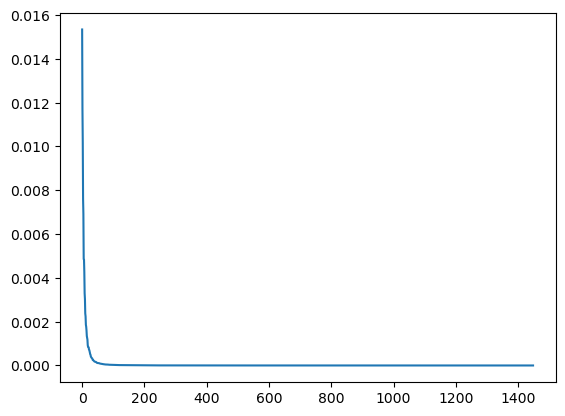

number of clusters:  40


C:\Users\patri\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


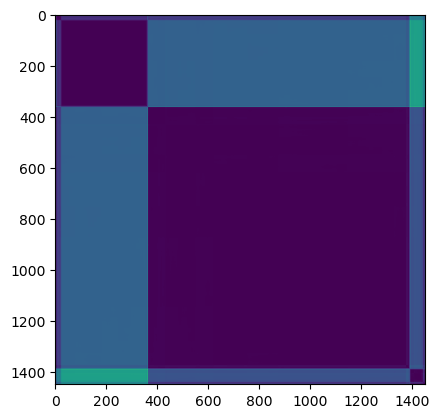

In [12]:
from scipy.stats import kendalltau
dist_mat = np.zeros((len(trip_arrays),len(trip_arrays)))
for i,t1 in enumerate(trip_arrays):
    for j,t2 in enumerate(trip_arrays[i+1:]):
        dist_mat[i,i+j+1] = abs(t1[:,0].max() - t2[:,0].max())
#         dist_mat[i,i+j+1] = kendalltau(t1[:,0],t2[:,0])[1] + kendalltau(t1[:,1],t2[:,1])[1]
#         dist_mat[i,i+j+1] = (1-kendalltau(t1[:,0],t2[:,0])[0]) * (1-kendalltau(t1[:,1],t2[:,1])[0])
#         x = ((t - np.mean(t,axis=0))*(t2 - np.mean(t2,axis=0))).sum(0)
#         y,z = np.linalg.norm((t - np.mean(t,axis=0)), axis=0),np.linalg.norm((t2 - np.mean(t2,axis=0)), axis=0)
#         dist_mat[i,i+j+1] = 1-x[0]*x[1]/(y[0]*y[1]*z[0]*z[1])
dist_mat += dist_mat.T
# .square( trip_arrays[:,None] - trip_arrays[None]).sum(-1).max(-1)**0.5
ag, lmat = autocluster(dist_mat, return_order=True, plot=True, affinity="precomputed", linkage='average')
order = lmat#['leaves']
plt.imshow(dist_mat[order][:,order])
plt.show()

In [14]:
correct_cluster = np.argmax([sum(ag.labels_==i) for i in range(ag.n_clusters)])
print("correct cluster is ", correct_cluster)
valid_arts = [ a for i,a in enumerate(all_arts) if ag.labels_[i]==correct_cluster]
print(len(valid_arts))

correct cluster is  1
940


In [69]:
## I could also just identify the spots where it stops
art_stops = []
for art in tqdm(valid_arts):
#     art = df[df.trip_id == artid]
    art = art.iloc[np.argsort(art.msg_time)]
    prev_speed = 1
    for _,row in art.iterrows():
        if row.speed_mph == 0:
            if prev_speed == 0:
                duration += str2time(row.msg_time) - stop_start
                stop_start = str2time(row.msg_time)
#                 continue
            else:
                stop_start = str2time(row.msg_time)
                prev_speed = 0
                duration = 0
                stop_location = (row.latitude, row.longitude)
        else:
            if prev_speed == 0:
                art_stops.append( (stop_location, duration))
        prev_speed = row.speed_mph

100%|████████████████████████| 940/940 [00:14<00:00, 65.50it/s]


In [70]:
# filter by how close they are to real stops
real_artstop_locations = [ stoplocations[s] for s,v in stopnames.items() if 'ART' in v]
real_artstop_locations

[{'lat': 35.070248, 'lng': -106.51563300000001},
 {'lat': 35.072183, 'lng': -106.533424},
 {'lat': 35.074090000000005, 'lng': -106.55088799999999},
 {'lat': 35.066138, 'lng': -106.498065},
 {'lat': 35.073714, 'lng': -106.549733},
 {'lat': 35.071742, 'lng': -106.531578},
 {'lat': 35.069891, 'lng': -106.514582},
 {'lat': 35.080046, 'lng': -106.710101},
 {'lat': 35.082701, 'lng': -106.69833100000001},
 {'lat': 35.085698, 'lng': -106.685129},
 {'lat': 35.094381, 'lng': -106.669974},
 {'lat': 35.089636999999996, 'lng': -106.66428700000002},
 {'lat': 35.083228000000005, 'lng': -106.641049},
 {'lat': 35.082217, 'lng': -106.633021},
 {'lat': 35.081338, 'lng': -106.626478},
 {'lat': 35.081053000000004, 'lng': -106.62011799999999},
 {'lat': 35.0805, 'lng': -106.609602},
 {'lat': 35.078859, 'lng': -106.595652},
 {'lat': 35.077876, 'lng': -106.586646},
 {'lat': 35.075996, 'lng': -106.56932900000001},
 {'lat': 35.080003000000005, 'lng': -106.71013899999998},
 {'lat': 35.082669, 'lng': -106.698365},

In [71]:
# art_stops = [ dict(lat=a[0][0], lng=a[0][1], duration=a[1], dist_to_station=min(geopy.distance.geodesic())]
art_stop_info = []
for a in tqdm(art_stops):
    lat = a[0][0]
    lng = a[0][1]
    duration = a[1]
    dist_to_station = min([geopy.distance.geodesic((lat,lng), (b['lat'], b['lng'])).feet for b in real_artstop_locations])
    art_stop_info.append(dict(lat=lat, lng=lng, duration=duration, dist_to_station=dist_to_station))

far_stops = [ a for a in art_stop_info if a['dist_to_station'] > 100 ]
len(far_stops)

100%|███████████████████| 28630/28630 [02:59<00:00, 159.31it/s]


13179

In [72]:
ag = AgglomerativeClustering(n_clusters=None, distance_threshold=300, linkage='complete')
ag.fit([ ll2euclid(d['lat'], d['lng']) for d in far_stops])

AgglomerativeClustering(distance_threshold=300, linkage='complete',
                        n_clusters=None)

In [73]:
# now find cluster centers and count total delay
cluster_groups = [[] for _ in range(ag.n_clusters_)]
for i,stop in enumerate(tqdm(far_stops)):
    cluster_groups[ag.labels_[i]].append(stop)

clusters = []
for i,gp in enumerate(tqdm(cluster_groups)):
    lat = np.mean([g['lat'] for g in gp])
    lng = np.mean([g['lng'] for g in gp])
    duration = sum([g['duration'] for g in gp])
    durations = [g['duration'] for g in gp]
    counts = len(gp)
    clusters.append( dict(lat=lat, lng=lng, duration=duration, counts=counts, durations=durations))

100%|█████████████████████| 201/201 [00:00<00:00, 10865.65it/s]


 32%|███████▋                | 64/201 [00:00<00:00, 596.49it/s]

loading image


100%|███████████████████████| 201/201 [00:00<00:00, 643.97it/s]


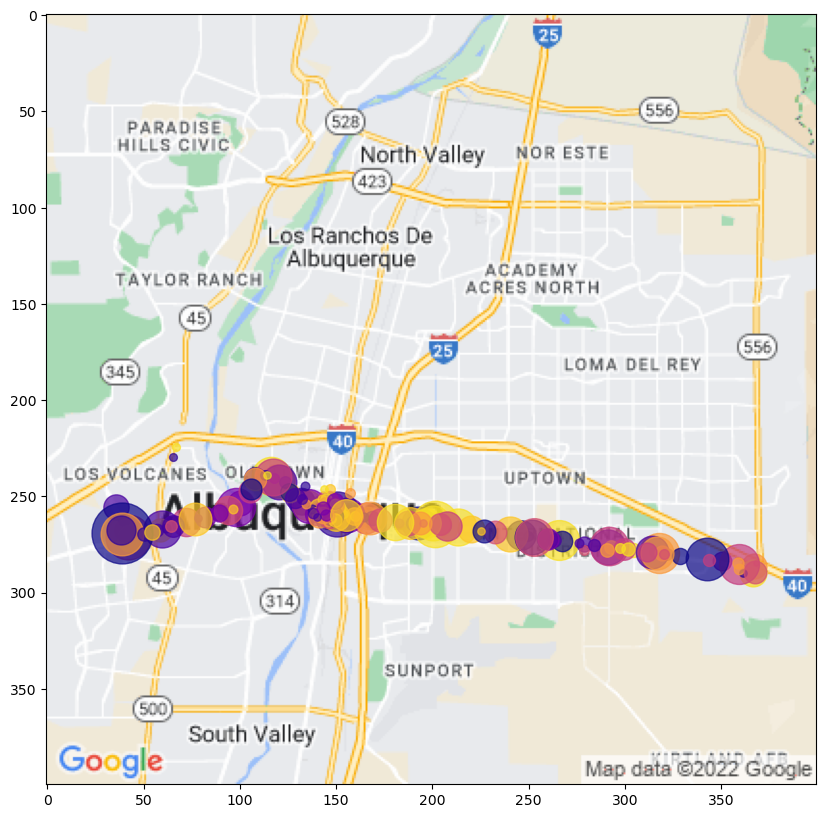

In [74]:
for i,cluster in enumerate(tqdm(clusters)):
    plot_abq([(cluster['lat'], cluster['lng'])], first=i==0, c=cm.plasma((ag.labels_[i] **2 % 17)/17), alpha=0.7, s=10*np.sqrt(cluster['duration']))


In [75]:
for i,cluster in enumerate(sorted(clusters, key=lambda x: -x['duration'])):
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ', cluster['duration']/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', cluster['duration'] / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
    print()


Cluster  1
	Lat/lon:  35.0787928 ,  -106.72528299
	Total delay:  617.5166666666667 min
	Number of stops:  329
	Average delay:  1.876950354609929 min
		25%ile: 0.133
		50%ile: 0.667
		75%ile: 1.867

Cluster  2
	Lat/lon:  35.08093618 ,  -106.61295124
	Total delay:  208.15 min
	Number of stops:  313
	Average delay:  0.6650159744408946 min
		25%ile: 0.133
		50%ile: 0.417
		75%ile: 0.933

Cluster  3
	Lat/lon:  35.08401577 ,  -106.64787891
	Total delay:  184.43333333333334 min
	Number of stops:  647
	Average delay:  0.285059247810407 min
		25%ile: 0.0
		50%ile: 0.267
		75%ile: 0.4

Cluster  4
	Lat/lon:  35.07737346 ,  -106.72308348
	Total delay:  182.76666666666668 min
	Number of stops:  304
	Average delay:  0.6012061403508772 min
		25%ile: 0.267
		50%ile: 0.533
		75%ile: 0.933

Cluster  5
	Lat/lon:  35.07841975 ,  -106.72517969
	Total delay:  149.23333333333332 min
	Number of stops:  30
	Average delay:  4.974444444444444 min
		25%ile: 1.075
		50%ile: 2.8
		75%ile: 7.667

Cluster  6
	Lat/lon

loading image


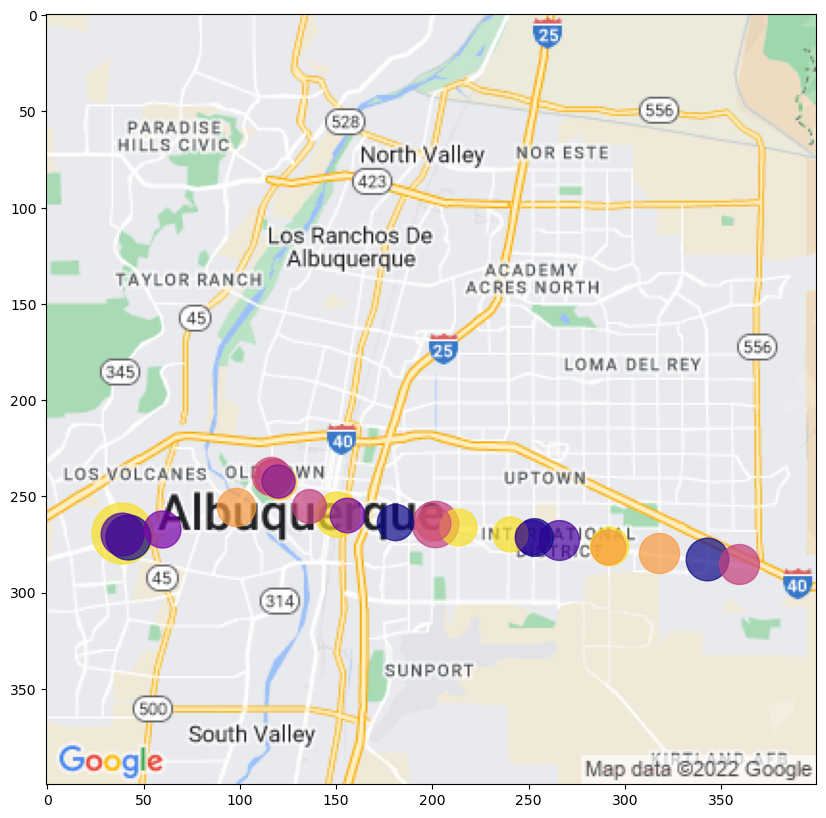

In [76]:
for i,cluster in enumerate(sorted(clusters, key=lambda x: -x['duration'])[:25]):
    plot_abq([(cluster['lat'], cluster['lng'])], first=i==0, c=cm.plasma((ag.labels_[i] **2 % 17)/17), alpha=0.7, s=10*np.sqrt(cluster['duration']))


In [77]:
(sum([ (c['duration'])  for c in clusters]) ) / (60*940)

4.54113475177305

# Auxiliary stuff

(array([  4.,  28., 220., 420., 234.,  31.,   2.,   0.,   0.,   1.]),
 array([ 708. , 1491.3, 2274.6, 3057.9, 3841.2, 4624.5, 5407.8, 6191.1,
        6974.4, 7757.7, 8541. ]),
 <BarContainer object of 10 artists>)

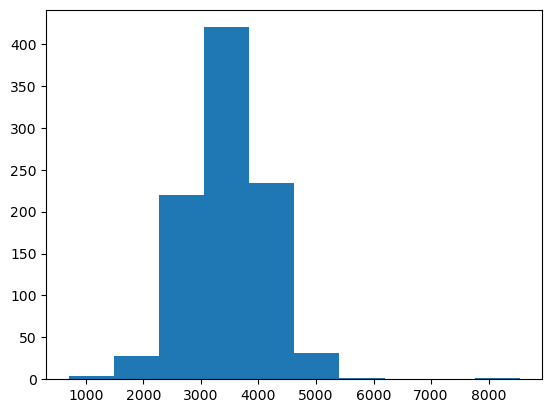

In [61]:
trip_durations = []
for art in valid_arts:
    msg_times = [str2time(t) for t in art.msg_time]
    trip_durations.append( max(msg_times) - min(msg_times))
plt.hist(trip_durations)

In [39]:
np.median(trip_durations)

3640.0